<a href="https://colab.research.google.com/github/hllj/RaceRegconitionVGG16/blob/master/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
CUR_DIR = '/content/drive/My Drive/Race'

In [0]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

#1.Check dataset:

In [0]:
RACE_LIST = ['Asian', 'Black', 'India', 'Others', 'White']

In [0]:
total = 0
class_weight = dict()
number_class = dict()
for idx, race in enumerate(RACE_LIST):
  class_weight[idx] = 0

In [0]:
for idx, race in enumerate(RACE_LIST):
  print(race, " has ", len(os.listdir(CUR_DIR + '//train//' + race)), " images in training set")
  print(race, " has ", len(os.listdir(CUR_DIR + '//test//' + race)), " images in testing set")
  class_weight[idx] = len(os.listdir(CUR_DIR + '//train//' + race)) + len(os.listdir(CUR_DIR + '//test//' + race))
  total += class_weight[idx]

Asian  has  1397  images in training set
Asian  has  156  images in testing set
Black  has  364  images in training set
Black  has  41  images in testing set
India  has  1307  images in training set
India  has  146  images in testing set
Others  has  992  images in training set
Others  has  111  images in testing set
White  has  4738  images in training set
White  has  527  images in testing set


In [0]:
for idx, race in enumerate(RACE_LIST):
  class_weight[idx] /= total

In [0]:
TRAINING_DIR = CUR_DIR + "//train//"
TESTING_DIR = CUR_DIR + "//test//"

#2.Create Image Generator from directory:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
TARGET_SIZE = (200, 200)
BATCH_SIZE = 128

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=TARGET_SIZE
)
test_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=TARGET_SIZE
)

Found 8798 images belonging to 5 classes.
Found 981 images belonging to 5 classes.


#3.Create Model:

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

In [0]:
NUM_CLASSES = 5

In [0]:
pretrained_model = VGG16(
    include_top = False,
    weights=None,
    input_shape=(200, 200, 3)
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
for layer in pretrained_model.layers:
  layer.trainable = False

In [0]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [0]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

In [0]:
print(last_output.shape)

(?, 6, 6, 512)


In [0]:
net = tf.keras.layers.Flatten()(last_output)
net = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(net)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(net)

model = tf.keras.Model(pretrained_model.input, net)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

#4.Training the model:

In [0]:
EPOCHS = 100
STEPS_PER_EPOCH = 70
VALIDATION_STEPS = 8
LR=0.001

In [0]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5", 
                                     monitor='val_acc',
                                     mode='max', 
                                     verbose=0, 
                                     save_best_only=True)

In [0]:
adam = tf.keras.optimizers.Adam(lr=LR, decay=LR/EPOCHS)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=2,
    validation_data=test_generator,
    callbacks=[mc],
    class_weight=class_weight
)

Epoch 1/100
Epoch 1/100
70/70 - 65s - loss: 0.2620 - acc: 0.5332 - val_loss: 1.5087 - val_acc: 0.5372
Epoch 2/100
Epoch 1/100
70/70 - 42s - loss: 0.2351 - acc: 0.5388 - val_loss: 1.5382 - val_acc: 0.5372
Epoch 3/100
Epoch 1/100
70/70 - 43s - loss: 0.2325 - acc: 0.5391 - val_loss: 1.5287 - val_acc: 0.5372
Epoch 4/100
Epoch 1/100
70/70 - 42s - loss: 0.2293 - acc: 0.5363 - val_loss: 1.4893 - val_acc: 0.5372
Epoch 5/100
Epoch 1/100
70/70 - 43s - loss: 0.2231 - acc: 0.5424 - val_loss: 1.4880 - val_acc: 0.5372
Epoch 6/100
Epoch 1/100
70/70 - 43s - loss: 0.2194 - acc: 0.5373 - val_loss: 1.4974 - val_acc: 0.5372
Epoch 7/100
Epoch 1/100
70/70 - 43s - loss: 0.2130 - acc: 0.5412 - val_loss: 1.4679 - val_acc: 0.5372
Epoch 8/100
Epoch 1/100
70/70 - 43s - loss: 0.2109 - acc: 0.5351 - val_loss: 1.3181 - val_acc: 0.5392
Epoch 9/100
Epoch 1/100
70/70 - 43s - loss: 0.2054 - acc: 0.5415 - val_loss: 1.3071 - val_acc: 0.5423
Epoch 10/100
Epoch 1/100
70/70 - 43s - loss: 0.2023 - acc: 0.5430 - val_loss: 1.34

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

In [0]:
range_epochs = range(1, EPOCHS + 1)

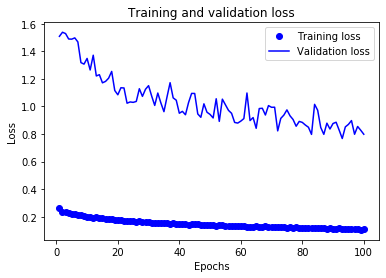

In [0]:
plt.plot(range_epochs, loss_values, 'bo', label='Training loss')
plt.plot(range_epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

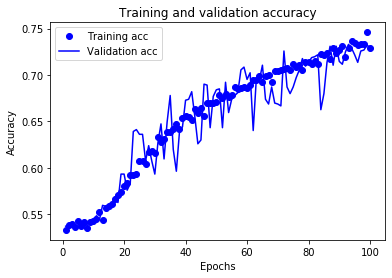

In [0]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(range_epochs, acc_values, 'bo', label='Training acc')
plt.plot(range_epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()